<a href="https://colab.research.google.com/github/rafaellopezgarcia/colab_notebooks/blob/main/ConvNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data

In [58]:
from google.colab import drive
from tabulate import tabulate
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms.v2 as v2
import matplotlib.pyplot as plt

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
trnsf = v2.Compose([
    v2.PILToTensor(),
    v2.RandomHorizontalFlip(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.5,0.5,0.5), std=(0.2,0.2,0.2))
])

trainvalset = torchvision.datasets.CIFAR10('./', download=True, transform=trnsf)
testset = torchvision.datasets.CIFAR10('./', train=False, download=True, transform=trnsf)

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170498071/170498071 [00:01<00:00, 105776170.03it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [4]:
trainvalset[1][0].shape

torch.Size([3, 32, 32])

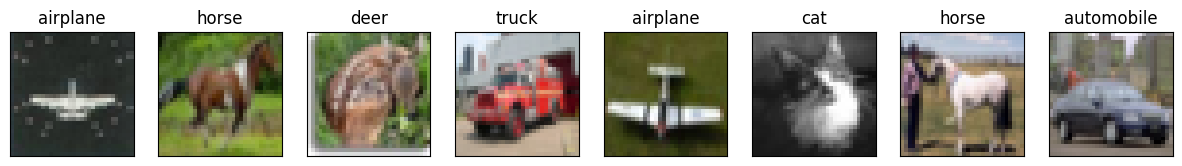

In [5]:
nimgs = 8
fig, axs = plt.subplots(1, nimgs, figsize=(15,10))

ixs = torch.randint(0, len(trainvalset), (nimgs,))
for plot_ix, img_ix in enumerate(ixs):
  x, y = trainvalset[img_ix]
  x = x * 0.2 + 0.5
  x = v2.functional.to_pil_image(x)
  axs[plot_ix].imshow(x)
  axs[plot_ix].set_xticks([])
  axs[plot_ix].set_yticks([])
  axs[plot_ix].set_title(labels[y])

In [6]:
class CifarDataset(Dataset):
  def __init__(self, trainset, split="train"):
    self.dataset = trainset
    self.split = split
    self.offset = 0
    if split != "train":
      self.offset = len(self.dataset) * (0.9)

  def __len__(self):
    if self.split == "train":
      return int(len(self.dataset) * 0.9)
    else:
      return int(len(self.dataset) * 0.1)

  def __getitem__(self, ix):
    if self.split == "train":
      return self.dataset[ix]
    else:
      return self.dataset[ix+self.offset]

In [7]:
valset = CifarDataset(trainvalset, split="val")
trainset = CifarDataset(trainvalset, split="train")

print(f"Size train dataset {int(len(trainvalset)*0.9)}")
print(f"Size validation dataset {int(len(trainvalset)*0.1)}")
print(f"Size test dataset {len(testset)}")

Size train dataset 45000
Size validation dataset 5000
Size test dataset 10000


In [8]:
batch_size = 8
train_dl = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(trainset, batch_size=int(len(trainvalset)*0.1), shuffle=True)

## Model

In [9]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 10, 4, 2) # in channels, out channels, K, S, P
    self.conv2 = nn.Conv2d(10, 10, 4, 1)
    self.conv3 = nn.Conv2d(10, 10, 3, 1)
    self.maxpool = nn.MaxPool2d(2)
    self.linear1 = nn.Linear(250, 600)
    self.linear2 = nn.Linear(600, 10)

  def forward(self, x, y=None):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = self.maxpool(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.linear1(x))
    x = self.linear2(x)

    if y is None:
      return x
    loss = F.cross_entropy(x, y)
    return x, loss

model = ConvNet()
x, y = next(iter(train_dl))
out, loss = model.forward(x, y)

In [10]:
def update_width(Win, K, S, P):
  Wout = (Win-K+2*P) / S + 1
  return Wout

Wout = update_width(32, 4, 2, 0)
print(Wout)
Wout = update_width(Wout, 4, 1, 0)
print(Wout)
Wout = update_width(Wout, 3, 1, 0)
print(Wout)

15.0
12.0
10.0


## Training

In [66]:
# Hyper-parameters
lr = 1e-3
epochs = 3
print_every = 1000
iterations = 30000
#batch_size = 8 (define above)

In [11]:
def train(model):
  opt = torch.optim.SGD(model.parameters(), lr, 0.9)

  it = 0
  avg_loss = 0
  for epoch in range(epochs):
    for xb, yb in train_dl:
      opt.zero_grad()
      logits, loss = model(xb, yb)
      loss.backward()
      opt.step()
      avg_loss += loss
      if (it+1)%print_every == 0:
        with torch.no_grad():
          xv, yv = next(iter(val_dl))
          _, val_loss = model(xv, yv)
          print(f"{it}/{iterations} loss: {avg_loss/print_every}, val loss {val_loss}")
          avg_loss = 0
      it+=1

train(model)


999/30000 loss: 2.196967363357544, val loss 2.0618274211883545
1999/30000 loss: 1.8996012210845947, val loss 1.7732197046279907
2999/30000 loss: 1.7005261182785034, val loss 1.6771169900894165
3999/30000 loss: 1.5898735523223877, val loss 1.5176244974136353
4999/30000 loss: 1.528071403503418, val loss 1.5267622470855713


### Save model

In [68]:
torch.save(model.state_dict(), '/content/drive/My Drive/neural_networks/models/cifar_convnet.pt')

## Evaluation

In [65]:
@torch.no_grad()
def evaluation(model, x, y):
  torch.set_printoptions(precision=2)
  logits = model.forward(x)
  scores = F.softmax(logits, 1)
  predictions = torch.argmax(scores, -1)
  predictions = F.one_hot(predictions)
  y = F.one_hot(y)
  accs = torch.sum(predictions * y, 0) / torch.sum(y, 0)
  acc = torch.sum(predictions * y) / len(y)

  out = [[labels[ix], accs[ix]] for ix in range(len(accs))]
  out.append(["TOTAL", acc])
  print(tabulate(out, headers=["Label", "Accuracy"]))

test_dl = DataLoader(testset, len(testset))
x, y = next(iter(test_dl))
evaluation(model, x, y)

label         accuracy
----------  ----------
airplane        0.449
automobile      0.551
bird            0.285
cat             0.55
deer            0.181
dog             0.301
frog            0.614
horse           0.642
ship            0.495
truck           0.656
TOTAL           0.4724


In [194]:
### S

0 5000
